In [1]:
import napari_clusters_plotter as ncp
import pyclesperanto_prototype as cle
import matplotlib.pyplot as plt
import pandas as pd
from skimage.io import imread, imsave
import napari
import os
from napari_clusters_plotter._measure import get_regprops_from_regprops_source

voxel_size_zyx = [3.0, 0.6934, 0.6934]

#Read csvFile that consists indices of files
filepath = "metadata.csv"
metadata = pd.read_csv(filepath)
metadata

,Unnamed: 0,time_in_s,original_index,index
0,0,0.0000,0,0
1,1,419.9778,5,1
2,2,779.9945,7,2
3,3,960.0141,8,3
4,4,1320.0067,10,4
...,...,...,...,...
426,427,128139.6458,2388,427
427,428,128739.9586,2389,428
428,429,128739.9586,2389,429
429,430,129339.7183,2390,430


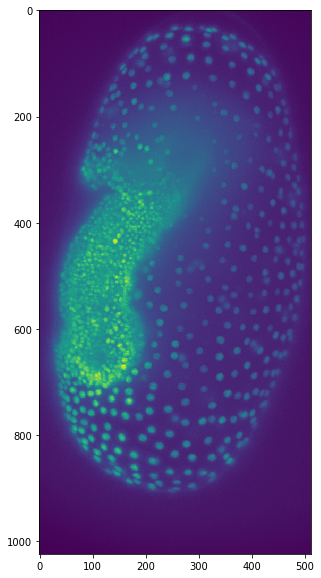

In [2]:
%matplotlib inline

data_location = "D:Uni/Data/Lund Zenodo/"
index = 240
filename = 'lund_i{0:06d}_oi_{1:06d}.tif'.format(metadata.index[index], metadata.original_index[index])
tribolium = imread(data_location + filename)

plt.figure(figsize=(10,10))
cle.imshow(tribolium)

In [3]:
filename[:-3]

'lund_i000240_oi_001352.'

In [4]:
# This workflow does a good job of approximating cellular regions around the nuclei
def workflow(image, number_of_dilations = 10, number_of_erosions = 4):
    import numpy as np
    import pyclesperanto_prototype as cle    

    gpu_input = cle.push(image)

    # Spot detection
    # After some noise removal/smoothing, we perform a local maximum detection

    # gaussian blur -> needs adjusting, maybe even other filters for preprocessing
    gpu_tophat = cle.top_hat_sphere(gpu_input,radius_x=7, radius_y=7, radius_z=7)
    gpu_blurred = cle.gaussian_blur(gpu_tophat, sigma_x=1, sigma_y=1, sigma_z=2) 
    gpu_input = None
    # detect maxima: instead of a pointslist we get and image with white pixels at the maxima locations
    gpu_detected_maxima = cle.detect_maxima_box(gpu_blurred)
    gpu_tophat = None
    # Spot curation
    # Now, we remove spots with values below a certain intensity and label the remaining spots

    # threshold
    gpu_thresholded = cle.threshold_otsu(gpu_blurred)
    gpu_blurred = None

    # mask
    gpu_masked_spots = cle.mask(gpu_detected_maxima, gpu_thresholded)
    gpu_detected_maxima = None
    gpu_thresholded = None
    # label spots
    gpu_labelled_spots = cle.connected_components_labeling_box(gpu_masked_spots)
    gpu_masked_spots = None
    
    number_of_spots = cle.maximum_of_all_pixels(gpu_labelled_spots)
    print("Number of detected spots: " + str(number_of_spots))
    # retrieve the image to take a look at the maxima in napari
    # label map closing

    flip = cle.create_like(gpu_labelled_spots)
    flop = cle.create_like(gpu_labelled_spots)
    flag = cle.create([1,1,1])
    cle.copy(gpu_labelled_spots, flip)

    for i in range (0, number_of_dilations) :
        cle.onlyzero_overwrite_maximum_box(flip, flag, flop)
        cle.onlyzero_overwrite_maximum_diamond(flop, flag, flip)
    
    gpu_labelled_spots = None
    
    flap = cle.greater_constant(flip, constant= 1)

    for i in range(0, number_of_erosions):
        cle.erode_box(flap, flop)
        cle.erode_sphere(flop, flap)

    gpu_labels = cle.mask(flip, flap)
    flip = None
    flop = None
    flap = None
    flag = None
    
    alllabels = cle.close_index_gaps_in_label_map(gpu_labels)
    output = cle.pull(alllabels)
    alllabels = None
    print('Label Numbering Starts at {val}'.format(val = np.min(output[np.nonzero(output)])))
    print('Workflow Completed')
    return output

In [6]:

outdir = "D:Uni\Data\Lund Zenodo\Processed"
ski_outdir = "D:Uni/Data/Lund Zenodo/Processed/"
if not os.path.exists(outdir):
    os.makedirs(outdir)
    
for i in (range(51,len(metadata))):
    filename = 'lund_i{0:06d}_oi_{1:06d}.tif'.format(metadata.index[i], metadata.original_index[i])
    image = imread(data_location + filename)

    rescaled = cle.pull(cle.resample(cle.push(tribolium), 
                                     factor_x=voxel_size_zyx[2], 
                                     factor_y=voxel_size_zyx[1], 
                                     factor_z=voxel_size_zyx[0]))
    imsave(ski_outdir + "rescaled_" + filename, rescaled)

    labels = workflow(rescaled)
    imsave(ski_outdir + "label_image_" + filename, labels)

    region_properties = pd.DataFrame(get_regprops_from_regprops_source(intensity_image = rescaled, 
                                                                       label_image = labels, 
                                                                       region_props_source = 'neighborhood', 
                                                                       n_closest_points_list= [2,3,4]))
    region_properties.to_csv(ski_outdir + "regionproperties_" + filename[:-3] + "csv")

Number of detected spots: 1533.0
Label Numbering Starts at 1
Workflow Completed


C:\Users\ryans\AppData\Local\Temp/ipykernel_11576/2170497234.py:17: UserWarning: D:Uni/Data/Lund Zenodo/Processed/label_image_lund_i000051_oi_000349.tif is a low contrast image
  imsave(ski_outdir + "label_image_" + filename, labels)


Measurements Completed.
Number of detected spots: 1533.0
Label Numbering Starts at 1
Workflow Completed


C:\Users\ryans\AppData\Local\Temp/ipykernel_11576/2170497234.py:17: UserWarning: D:Uni/Data/Lund Zenodo/Processed/label_image_lund_i000052_oi_000364.tif is a low contrast image
  imsave(ski_outdir + "label_image_" + filename, labels)


Measurements Completed.
Number of detected spots: 1533.0
Label Numbering Starts at 1
Workflow Completed


C:\Users\ryans\AppData\Local\Temp/ipykernel_11576/2170497234.py:17: UserWarning: D:Uni/Data/Lund Zenodo/Processed/label_image_lund_i000053_oi_000370.tif is a low contrast image
  imsave(ski_outdir + "label_image_" + filename, labels)


Measurements Completed.
Number of detected spots: 1533.0
Label Numbering Starts at 1
Workflow Completed


C:\Users\ryans\AppData\Local\Temp/ipykernel_11576/2170497234.py:17: UserWarning: D:Uni/Data/Lund Zenodo/Processed/label_image_lund_i000054_oi_000372.tif is a low contrast image
  imsave(ski_outdir + "label_image_" + filename, labels)


Measurements Completed.
Number of detected spots: 1533.0
Label Numbering Starts at 1
Workflow Completed


C:\Users\ryans\AppData\Local\Temp/ipykernel_11576/2170497234.py:17: UserWarning: D:Uni/Data/Lund Zenodo/Processed/label_image_lund_i000055_oi_000375.tif is a low contrast image
  imsave(ski_outdir + "label_image_" + filename, labels)


Measurements Completed.
Number of detected spots: 1533.0
Label Numbering Starts at 1
Workflow Completed


C:\Users\ryans\AppData\Local\Temp/ipykernel_11576/2170497234.py:17: UserWarning: D:Uni/Data/Lund Zenodo/Processed/label_image_lund_i000056_oi_000377.tif is a low contrast image
  imsave(ski_outdir + "label_image_" + filename, labels)


Measurements Completed.
Number of detected spots: 1533.0
Label Numbering Starts at 1
Workflow Completed


C:\Users\ryans\AppData\Local\Temp/ipykernel_11576/2170497234.py:17: UserWarning: D:Uni/Data/Lund Zenodo/Processed/label_image_lund_i000057_oi_000379.tif is a low contrast image
  imsave(ski_outdir + "label_image_" + filename, labels)


Measurements Completed.
Number of detected spots: 1533.0
Label Numbering Starts at 1
Workflow Completed


C:\Users\ryans\AppData\Local\Temp/ipykernel_11576/2170497234.py:17: UserWarning: D:Uni/Data/Lund Zenodo/Processed/label_image_lund_i000058_oi_000381.tif is a low contrast image
  imsave(ski_outdir + "label_image_" + filename, labels)


Measurements Completed.
Number of detected spots: 1533.0
Label Numbering Starts at 1
Workflow Completed


C:\Users\ryans\AppData\Local\Temp/ipykernel_11576/2170497234.py:17: UserWarning: D:Uni/Data/Lund Zenodo/Processed/label_image_lund_i000059_oi_000382.tif is a low contrast image
  imsave(ski_outdir + "label_image_" + filename, labels)


Measurements Completed.
Number of detected spots: 1533.0
Label Numbering Starts at 1
Workflow Completed


C:\Users\ryans\AppData\Local\Temp/ipykernel_11576/2170497234.py:17: UserWarning: D:Uni/Data/Lund Zenodo/Processed/label_image_lund_i000060_oi_000384.tif is a low contrast image
  imsave(ski_outdir + "label_image_" + filename, labels)


Measurements Completed.
Number of detected spots: 1533.0
Label Numbering Starts at 1
Workflow Completed


C:\Users\ryans\AppData\Local\Temp/ipykernel_11576/2170497234.py:17: UserWarning: D:Uni/Data/Lund Zenodo/Processed/label_image_lund_i000061_oi_000386.tif is a low contrast image
  imsave(ski_outdir + "label_image_" + filename, labels)


Measurements Completed.
Number of detected spots: 1533.0
Label Numbering Starts at 1
Workflow Completed


C:\Users\ryans\AppData\Local\Temp/ipykernel_11576/2170497234.py:17: UserWarning: D:Uni/Data/Lund Zenodo/Processed/label_image_lund_i000062_oi_000387.tif is a low contrast image
  imsave(ski_outdir + "label_image_" + filename, labels)


Measurements Completed.
Number of detected spots: 1533.0
Label Numbering Starts at 1
Workflow Completed


C:\Users\ryans\AppData\Local\Temp/ipykernel_11576/2170497234.py:17: UserWarning: D:Uni/Data/Lund Zenodo/Processed/label_image_lund_i000063_oi_000389.tif is a low contrast image
  imsave(ski_outdir + "label_image_" + filename, labels)


Measurements Completed.
Number of detected spots: 1533.0
Label Numbering Starts at 1
Workflow Completed


C:\Users\ryans\AppData\Local\Temp/ipykernel_11576/2170497234.py:17: UserWarning: D:Uni/Data/Lund Zenodo/Processed/label_image_lund_i000064_oi_000391.tif is a low contrast image
  imsave(ski_outdir + "label_image_" + filename, labels)


Measurements Completed.
Number of detected spots: 1533.0
Label Numbering Starts at 1
Workflow Completed


C:\Users\ryans\AppData\Local\Temp/ipykernel_11576/2170497234.py:17: UserWarning: D:Uni/Data/Lund Zenodo/Processed/label_image_lund_i000065_oi_000392.tif is a low contrast image
  imsave(ski_outdir + "label_image_" + filename, labels)


Measurements Completed.
Number of detected spots: 1533.0
Label Numbering Starts at 1
Workflow Completed


C:\Users\ryans\AppData\Local\Temp/ipykernel_11576/2170497234.py:17: UserWarning: D:Uni/Data/Lund Zenodo/Processed/label_image_lund_i000066_oi_000394.tif is a low contrast image
  imsave(ski_outdir + "label_image_" + filename, labels)


Measurements Completed.
Number of detected spots: 1533.0
Label Numbering Starts at 1
Workflow Completed


C:\Users\ryans\AppData\Local\Temp/ipykernel_11576/2170497234.py:17: UserWarning: D:Uni/Data/Lund Zenodo/Processed/label_image_lund_i000067_oi_000396.tif is a low contrast image
  imsave(ski_outdir + "label_image_" + filename, labels)


Measurements Completed.
Number of detected spots: 1533.0
Label Numbering Starts at 1
Workflow Completed


C:\Users\ryans\AppData\Local\Temp/ipykernel_11576/2170497234.py:17: UserWarning: D:Uni/Data/Lund Zenodo/Processed/label_image_lund_i000068_oi_000397.tif is a low contrast image
  imsave(ski_outdir + "label_image_" + filename, labels)


Measurements Completed.
Number of detected spots: 1533.0
Label Numbering Starts at 1
Workflow Completed


C:\Users\ryans\AppData\Local\Temp/ipykernel_11576/2170497234.py:17: UserWarning: D:Uni/Data/Lund Zenodo/Processed/label_image_lund_i000069_oi_000399.tif is a low contrast image
  imsave(ski_outdir + "label_image_" + filename, labels)


Measurements Completed.
Number of detected spots: 1533.0
Label Numbering Starts at 1
Workflow Completed


C:\Users\ryans\AppData\Local\Temp/ipykernel_11576/2170497234.py:17: UserWarning: D:Uni/Data/Lund Zenodo/Processed/label_image_lund_i000070_oi_000401.tif is a low contrast image
  imsave(ski_outdir + "label_image_" + filename, labels)


Measurements Completed.
Number of detected spots: 1533.0
Label Numbering Starts at 1
Workflow Completed


C:\Users\ryans\AppData\Local\Temp/ipykernel_11576/2170497234.py:17: UserWarning: D:Uni/Data/Lund Zenodo/Processed/label_image_lund_i000071_oi_000402.tif is a low contrast image
  imsave(ski_outdir + "label_image_" + filename, labels)


Measurements Completed.
Number of detected spots: 1533.0
Label Numbering Starts at 1
Workflow Completed


C:\Users\ryans\AppData\Local\Temp/ipykernel_11576/2170497234.py:17: UserWarning: D:Uni/Data/Lund Zenodo/Processed/label_image_lund_i000072_oi_000404.tif is a low contrast image
  imsave(ski_outdir + "label_image_" + filename, labels)


Measurements Completed.
Number of detected spots: 1533.0
Label Numbering Starts at 1
Workflow Completed


C:\Users\ryans\AppData\Local\Temp/ipykernel_11576/2170497234.py:17: UserWarning: D:Uni/Data/Lund Zenodo/Processed/label_image_lund_i000073_oi_000406.tif is a low contrast image
  imsave(ski_outdir + "label_image_" + filename, labels)


Measurements Completed.
Number of detected spots: 1533.0
Label Numbering Starts at 1
Workflow Completed


C:\Users\ryans\AppData\Local\Temp/ipykernel_11576/2170497234.py:17: UserWarning: D:Uni/Data/Lund Zenodo/Processed/label_image_lund_i000074_oi_000407.tif is a low contrast image
  imsave(ski_outdir + "label_image_" + filename, labels)


Measurements Completed.
Number of detected spots: 1533.0
Label Numbering Starts at 1
Workflow Completed


C:\Users\ryans\AppData\Local\Temp/ipykernel_11576/2170497234.py:17: UserWarning: D:Uni/Data/Lund Zenodo/Processed/label_image_lund_i000075_oi_000409.tif is a low contrast image
  imsave(ski_outdir + "label_image_" + filename, labels)


Measurements Completed.
Number of detected spots: 1533.0
Label Numbering Starts at 1
Workflow Completed


C:\Users\ryans\AppData\Local\Temp/ipykernel_11576/2170497234.py:17: UserWarning: D:Uni/Data/Lund Zenodo/Processed/label_image_lund_i000076_oi_000412.tif is a low contrast image
  imsave(ski_outdir + "label_image_" + filename, labels)


Measurements Completed.
Number of detected spots: 1533.0
Label Numbering Starts at 1
Workflow Completed


C:\Users\ryans\AppData\Local\Temp/ipykernel_11576/2170497234.py:17: UserWarning: D:Uni/Data/Lund Zenodo/Processed/label_image_lund_i000077_oi_000427.tif is a low contrast image
  imsave(ski_outdir + "label_image_" + filename, labels)


Measurements Completed.
Number of detected spots: 1533.0
Label Numbering Starts at 1
Workflow Completed


C:\Users\ryans\AppData\Local\Temp/ipykernel_11576/2170497234.py:17: UserWarning: D:Uni/Data/Lund Zenodo/Processed/label_image_lund_i000078_oi_000442.tif is a low contrast image
  imsave(ski_outdir + "label_image_" + filename, labels)


Measurements Completed.
Number of detected spots: 1533.0
Label Numbering Starts at 1
Workflow Completed


C:\Users\ryans\AppData\Local\Temp/ipykernel_11576/2170497234.py:17: UserWarning: D:Uni/Data/Lund Zenodo/Processed/label_image_lund_i000079_oi_000457.tif is a low contrast image
  imsave(ski_outdir + "label_image_" + filename, labels)


Measurements Completed.
Number of detected spots: 1533.0
Label Numbering Starts at 1
Workflow Completed


C:\Users\ryans\AppData\Local\Temp/ipykernel_11576/2170497234.py:17: UserWarning: D:Uni/Data/Lund Zenodo/Processed/label_image_lund_i000080_oi_000472.tif is a low contrast image
  imsave(ski_outdir + "label_image_" + filename, labels)


Measurements Completed.
Number of detected spots: 1533.0
Label Numbering Starts at 1
Workflow Completed


C:\Users\ryans\AppData\Local\Temp/ipykernel_11576/2170497234.py:17: UserWarning: D:Uni/Data/Lund Zenodo/Processed/label_image_lund_i000081_oi_000487.tif is a low contrast image
  imsave(ski_outdir + "label_image_" + filename, labels)


Measurements Completed.
Number of detected spots: 1533.0
Label Numbering Starts at 1
Workflow Completed


C:\Users\ryans\AppData\Local\Temp/ipykernel_11576/2170497234.py:17: UserWarning: D:Uni/Data/Lund Zenodo/Processed/label_image_lund_i000082_oi_000502.tif is a low contrast image
  imsave(ski_outdir + "label_image_" + filename, labels)


Measurements Completed.
Number of detected spots: 1533.0
Label Numbering Starts at 1
Workflow Completed


C:\Users\ryans\AppData\Local\Temp/ipykernel_11576/2170497234.py:17: UserWarning: D:Uni/Data/Lund Zenodo/Processed/label_image_lund_i000083_oi_000517.tif is a low contrast image
  imsave(ski_outdir + "label_image_" + filename, labels)


Measurements Completed.
Number of detected spots: 1533.0
Label Numbering Starts at 1
Workflow Completed


C:\Users\ryans\AppData\Local\Temp/ipykernel_11576/2170497234.py:17: UserWarning: D:Uni/Data/Lund Zenodo/Processed/label_image_lund_i000084_oi_000532.tif is a low contrast image
  imsave(ski_outdir + "label_image_" + filename, labels)


Measurements Completed.
Number of detected spots: 1533.0
Label Numbering Starts at 1
Workflow Completed


C:\Users\ryans\AppData\Local\Temp/ipykernel_11576/2170497234.py:17: UserWarning: D:Uni/Data/Lund Zenodo/Processed/label_image_lund_i000085_oi_000547.tif is a low contrast image
  imsave(ski_outdir + "label_image_" + filename, labels)


Measurements Completed.
Number of detected spots: 1533.0
Label Numbering Starts at 1
Workflow Completed


C:\Users\ryans\AppData\Local\Temp/ipykernel_11576/2170497234.py:17: UserWarning: D:Uni/Data/Lund Zenodo/Processed/label_image_lund_i000086_oi_000562.tif is a low contrast image
  imsave(ski_outdir + "label_image_" + filename, labels)


Measurements Completed.
Number of detected spots: 1533.0
Label Numbering Starts at 1
Workflow Completed


C:\Users\ryans\AppData\Local\Temp/ipykernel_11576/2170497234.py:17: UserWarning: D:Uni/Data/Lund Zenodo/Processed/label_image_lund_i000087_oi_000577.tif is a low contrast image
  imsave(ski_outdir + "label_image_" + filename, labels)


Measurements Completed.
Number of detected spots: 1533.0
Label Numbering Starts at 1
Workflow Completed


C:\Users\ryans\AppData\Local\Temp/ipykernel_11576/2170497234.py:17: UserWarning: D:Uni/Data/Lund Zenodo/Processed/label_image_lund_i000088_oi_000592.tif is a low contrast image
  imsave(ski_outdir + "label_image_" + filename, labels)


Measurements Completed.
Number of detected spots: 1533.0
Label Numbering Starts at 1
Workflow Completed


C:\Users\ryans\AppData\Local\Temp/ipykernel_11576/2170497234.py:17: UserWarning: D:Uni/Data/Lund Zenodo/Processed/label_image_lund_i000089_oi_000607.tif is a low contrast image
  imsave(ski_outdir + "label_image_" + filename, labels)


Measurements Completed.
Number of detected spots: 1533.0
Label Numbering Starts at 1
Workflow Completed


C:\Users\ryans\AppData\Local\Temp/ipykernel_11576/2170497234.py:17: UserWarning: D:Uni/Data/Lund Zenodo/Processed/label_image_lund_i000090_oi_000622.tif is a low contrast image
  imsave(ski_outdir + "label_image_" + filename, labels)


Measurements Completed.
Number of detected spots: 1533.0
Label Numbering Starts at 1
Workflow Completed


C:\Users\ryans\AppData\Local\Temp/ipykernel_11576/2170497234.py:17: UserWarning: D:Uni/Data/Lund Zenodo/Processed/label_image_lund_i000091_oi_000637.tif is a low contrast image
  imsave(ski_outdir + "label_image_" + filename, labels)


Measurements Completed.
Number of detected spots: 1533.0
Label Numbering Starts at 1
Workflow Completed


C:\Users\ryans\AppData\Local\Temp/ipykernel_11576/2170497234.py:17: UserWarning: D:Uni/Data/Lund Zenodo/Processed/label_image_lund_i000092_oi_000641.tif is a low contrast image
  imsave(ski_outdir + "label_image_" + filename, labels)


Measurements Completed.
Number of detected spots: 1533.0
Label Numbering Starts at 1
Workflow Completed


C:\Users\ryans\AppData\Local\Temp/ipykernel_11576/2170497234.py:17: UserWarning: D:Uni/Data/Lund Zenodo/Processed/label_image_lund_i000093_oi_000643.tif is a low contrast image
  imsave(ski_outdir + "label_image_" + filename, labels)


Measurements Completed.
Number of detected spots: 1533.0
Label Numbering Starts at 1
Workflow Completed


C:\Users\ryans\AppData\Local\Temp/ipykernel_11576/2170497234.py:17: UserWarning: D:Uni/Data/Lund Zenodo/Processed/label_image_lund_i000094_oi_000647.tif is a low contrast image
  imsave(ski_outdir + "label_image_" + filename, labels)


Measurements Completed.
Number of detected spots: 1533.0
Label Numbering Starts at 1
Workflow Completed


C:\Users\ryans\AppData\Local\Temp/ipykernel_11576/2170497234.py:17: UserWarning: D:Uni/Data/Lund Zenodo/Processed/label_image_lund_i000095_oi_000649.tif is a low contrast image
  imsave(ski_outdir + "label_image_" + filename, labels)


Measurements Completed.
Number of detected spots: 1533.0
Label Numbering Starts at 1
Workflow Completed


C:\Users\ryans\AppData\Local\Temp/ipykernel_11576/2170497234.py:17: UserWarning: D:Uni/Data/Lund Zenodo/Processed/label_image_lund_i000096_oi_000651.tif is a low contrast image
  imsave(ski_outdir + "label_image_" + filename, labels)


Measurements Completed.
Number of detected spots: 1533.0
Label Numbering Starts at 1
Workflow Completed


C:\Users\ryans\AppData\Local\Temp/ipykernel_11576/2170497234.py:17: UserWarning: D:Uni/Data/Lund Zenodo/Processed/label_image_lund_i000097_oi_000653.tif is a low contrast image
  imsave(ski_outdir + "label_image_" + filename, labels)


Measurements Completed.
Number of detected spots: 1533.0
Label Numbering Starts at 1
Workflow Completed


C:\Users\ryans\AppData\Local\Temp/ipykernel_11576/2170497234.py:17: UserWarning: D:Uni/Data/Lund Zenodo/Processed/label_image_lund_i000098_oi_000654.tif is a low contrast image
  imsave(ski_outdir + "label_image_" + filename, labels)


Measurements Completed.
Number of detected spots: 1533.0
Label Numbering Starts at 1
Workflow Completed


C:\Users\ryans\AppData\Local\Temp/ipykernel_11576/2170497234.py:17: UserWarning: D:Uni/Data/Lund Zenodo/Processed/label_image_lund_i000099_oi_000656.tif is a low contrast image
  imsave(ski_outdir + "label_image_" + filename, labels)


Measurements Completed.
Number of detected spots: 1533.0
Label Numbering Starts at 1
Workflow Completed


C:\Users\ryans\AppData\Local\Temp/ipykernel_11576/2170497234.py:17: UserWarning: D:Uni/Data/Lund Zenodo/Processed/label_image_lund_i000100_oi_000658.tif is a low contrast image
  imsave(ski_outdir + "label_image_" + filename, labels)


Measurements Completed.
Number of detected spots: 1533.0
Label Numbering Starts at 1
Workflow Completed


C:\Users\ryans\AppData\Local\Temp/ipykernel_11576/2170497234.py:17: UserWarning: D:Uni/Data/Lund Zenodo/Processed/label_image_lund_i000101_oi_000659.tif is a low contrast image
  imsave(ski_outdir + "label_image_" + filename, labels)


Measurements Completed.
Number of detected spots: 1533.0
Label Numbering Starts at 1
Workflow Completed


C:\Users\ryans\AppData\Local\Temp/ipykernel_11576/2170497234.py:17: UserWarning: D:Uni/Data/Lund Zenodo/Processed/label_image_lund_i000102_oi_000661.tif is a low contrast image
  imsave(ski_outdir + "label_image_" + filename, labels)


Measurements Completed.
Number of detected spots: 1533.0
Label Numbering Starts at 1
Workflow Completed


C:\Users\ryans\AppData\Local\Temp/ipykernel_11576/2170497234.py:17: UserWarning: D:Uni/Data/Lund Zenodo/Processed/label_image_lund_i000103_oi_000663.tif is a low contrast image
  imsave(ski_outdir + "label_image_" + filename, labels)


Measurements Completed.
Number of detected spots: 1533.0
Label Numbering Starts at 1
Workflow Completed


C:\Users\ryans\AppData\Local\Temp/ipykernel_11576/2170497234.py:17: UserWarning: D:Uni/Data/Lund Zenodo/Processed/label_image_lund_i000104_oi_000664.tif is a low contrast image
  imsave(ski_outdir + "label_image_" + filename, labels)


Measurements Completed.
Number of detected spots: 1533.0
Label Numbering Starts at 1
Workflow Completed


C:\Users\ryans\AppData\Local\Temp/ipykernel_11576/2170497234.py:17: UserWarning: D:Uni/Data/Lund Zenodo/Processed/label_image_lund_i000105_oi_000666.tif is a low contrast image
  imsave(ski_outdir + "label_image_" + filename, labels)


Measurements Completed.
Number of detected spots: 1533.0
Label Numbering Starts at 1
Workflow Completed


C:\Users\ryans\AppData\Local\Temp/ipykernel_11576/2170497234.py:17: UserWarning: D:Uni/Data/Lund Zenodo/Processed/label_image_lund_i000106_oi_000668.tif is a low contrast image
  imsave(ski_outdir + "label_image_" + filename, labels)


Measurements Completed.
Number of detected spots: 1533.0
Label Numbering Starts at 1
Workflow Completed


C:\Users\ryans\AppData\Local\Temp/ipykernel_11576/2170497234.py:17: UserWarning: D:Uni/Data/Lund Zenodo/Processed/label_image_lund_i000107_oi_000669.tif is a low contrast image
  imsave(ski_outdir + "label_image_" + filename, labels)


Measurements Completed.
Number of detected spots: 1533.0
Label Numbering Starts at 1
Workflow Completed


C:\Users\ryans\AppData\Local\Temp/ipykernel_11576/2170497234.py:17: UserWarning: D:Uni/Data/Lund Zenodo/Processed/label_image_lund_i000108_oi_000671.tif is a low contrast image
  imsave(ski_outdir + "label_image_" + filename, labels)


Measurements Completed.
Number of detected spots: 1533.0
Label Numbering Starts at 1
Workflow Completed


C:\Users\ryans\AppData\Local\Temp/ipykernel_11576/2170497234.py:17: UserWarning: D:Uni/Data/Lund Zenodo/Processed/label_image_lund_i000109_oi_000673.tif is a low contrast image
  imsave(ski_outdir + "label_image_" + filename, labels)


Measurements Completed.
Number of detected spots: 1533.0
Label Numbering Starts at 1
Workflow Completed


C:\Users\ryans\AppData\Local\Temp/ipykernel_11576/2170497234.py:17: UserWarning: D:Uni/Data/Lund Zenodo/Processed/label_image_lund_i000110_oi_000674.tif is a low contrast image
  imsave(ski_outdir + "label_image_" + filename, labels)


Measurements Completed.
Number of detected spots: 1533.0
Label Numbering Starts at 1
Workflow Completed


C:\Users\ryans\AppData\Local\Temp/ipykernel_11576/2170497234.py:17: UserWarning: D:Uni/Data/Lund Zenodo/Processed/label_image_lund_i000111_oi_000676.tif is a low contrast image
  imsave(ski_outdir + "label_image_" + filename, labels)


Measurements Completed.
Number of detected spots: 1533.0
Label Numbering Starts at 1
Workflow Completed


C:\Users\ryans\AppData\Local\Temp/ipykernel_11576/2170497234.py:17: UserWarning: D:Uni/Data/Lund Zenodo/Processed/label_image_lund_i000112_oi_000678.tif is a low contrast image
  imsave(ski_outdir + "label_image_" + filename, labels)


Measurements Completed.
Number of detected spots: 1533.0
Label Numbering Starts at 1
Workflow Completed


C:\Users\ryans\AppData\Local\Temp/ipykernel_11576/2170497234.py:17: UserWarning: D:Uni/Data/Lund Zenodo/Processed/label_image_lund_i000113_oi_000679.tif is a low contrast image
  imsave(ski_outdir + "label_image_" + filename, labels)


Measurements Completed.
Number of detected spots: 1533.0
Label Numbering Starts at 1
Workflow Completed


C:\Users\ryans\AppData\Local\Temp/ipykernel_11576/2170497234.py:17: UserWarning: D:Uni/Data/Lund Zenodo/Processed/label_image_lund_i000114_oi_000681.tif is a low contrast image
  imsave(ski_outdir + "label_image_" + filename, labels)


Measurements Completed.
Number of detected spots: 1533.0
Label Numbering Starts at 1
Workflow Completed


C:\Users\ryans\AppData\Local\Temp/ipykernel_11576/2170497234.py:17: UserWarning: D:Uni/Data/Lund Zenodo/Processed/label_image_lund_i000115_oi_000683.tif is a low contrast image
  imsave(ski_outdir + "label_image_" + filename, labels)


Measurements Completed.
Number of detected spots: 1533.0
Label Numbering Starts at 1
Workflow Completed


C:\Users\ryans\AppData\Local\Temp/ipykernel_11576/2170497234.py:17: UserWarning: D:Uni/Data/Lund Zenodo/Processed/label_image_lund_i000116_oi_000684.tif is a low contrast image
  imsave(ski_outdir + "label_image_" + filename, labels)


Measurements Completed.
Number of detected spots: 1533.0
Label Numbering Starts at 1
Workflow Completed


C:\Users\ryans\AppData\Local\Temp/ipykernel_11576/2170497234.py:17: UserWarning: D:Uni/Data/Lund Zenodo/Processed/label_image_lund_i000117_oi_000686.tif is a low contrast image
  imsave(ski_outdir + "label_image_" + filename, labels)


Measurements Completed.
Number of detected spots: 1533.0
Label Numbering Starts at 1
Workflow Completed


C:\Users\ryans\AppData\Local\Temp/ipykernel_11576/2170497234.py:17: UserWarning: D:Uni/Data/Lund Zenodo/Processed/label_image_lund_i000118_oi_000688.tif is a low contrast image
  imsave(ski_outdir + "label_image_" + filename, labels)


Measurements Completed.
Number of detected spots: 1533.0
Label Numbering Starts at 1
Workflow Completed


C:\Users\ryans\AppData\Local\Temp/ipykernel_11576/2170497234.py:17: UserWarning: D:Uni/Data/Lund Zenodo/Processed/label_image_lund_i000119_oi_000689.tif is a low contrast image
  imsave(ski_outdir + "label_image_" + filename, labels)


Measurements Completed.
Number of detected spots: 1533.0
Label Numbering Starts at 1
Workflow Completed


C:\Users\ryans\AppData\Local\Temp/ipykernel_11576/2170497234.py:17: UserWarning: D:Uni/Data/Lund Zenodo/Processed/label_image_lund_i000120_oi_000691.tif is a low contrast image
  imsave(ski_outdir + "label_image_" + filename, labels)


Measurements Completed.
Number of detected spots: 1533.0
Label Numbering Starts at 1
Workflow Completed


C:\Users\ryans\AppData\Local\Temp/ipykernel_11576/2170497234.py:17: UserWarning: D:Uni/Data/Lund Zenodo/Processed/label_image_lund_i000121_oi_000693.tif is a low contrast image
  imsave(ski_outdir + "label_image_" + filename, labels)


Measurements Completed.
Number of detected spots: 1533.0
Label Numbering Starts at 1
Workflow Completed


C:\Users\ryans\AppData\Local\Temp/ipykernel_11576/2170497234.py:17: UserWarning: D:Uni/Data/Lund Zenodo/Processed/label_image_lund_i000122_oi_000694.tif is a low contrast image
  imsave(ski_outdir + "label_image_" + filename, labels)


Measurements Completed.
Number of detected spots: 1533.0
Label Numbering Starts at 1
Workflow Completed


C:\Users\ryans\AppData\Local\Temp/ipykernel_11576/2170497234.py:17: UserWarning: D:Uni/Data/Lund Zenodo/Processed/label_image_lund_i000123_oi_000696.tif is a low contrast image
  imsave(ski_outdir + "label_image_" + filename, labels)


Measurements Completed.
Number of detected spots: 1533.0
Label Numbering Starts at 1
Workflow Completed


C:\Users\ryans\AppData\Local\Temp/ipykernel_11576/2170497234.py:17: UserWarning: D:Uni/Data/Lund Zenodo/Processed/label_image_lund_i000124_oi_000698.tif is a low contrast image
  imsave(ski_outdir + "label_image_" + filename, labels)


Measurements Completed.
Number of detected spots: 1533.0
Label Numbering Starts at 1
Workflow Completed


C:\Users\ryans\AppData\Local\Temp/ipykernel_11576/2170497234.py:17: UserWarning: D:Uni/Data/Lund Zenodo/Processed/label_image_lund_i000125_oi_000699.tif is a low contrast image
  imsave(ski_outdir + "label_image_" + filename, labels)


Measurements Completed.
Number of detected spots: 1533.0
Label Numbering Starts at 1
Workflow Completed


C:\Users\ryans\AppData\Local\Temp/ipykernel_11576/2170497234.py:17: UserWarning: D:Uni/Data/Lund Zenodo/Processed/label_image_lund_i000126_oi_000701.tif is a low contrast image
  imsave(ski_outdir + "label_image_" + filename, labels)


Measurements Completed.
Number of detected spots: 1533.0
Label Numbering Starts at 1
Workflow Completed


C:\Users\ryans\AppData\Local\Temp/ipykernel_11576/2170497234.py:17: UserWarning: D:Uni/Data/Lund Zenodo/Processed/label_image_lund_i000127_oi_000703.tif is a low contrast image
  imsave(ski_outdir + "label_image_" + filename, labels)


Measurements Completed.
Number of detected spots: 1533.0
Label Numbering Starts at 1
Workflow Completed


C:\Users\ryans\AppData\Local\Temp/ipykernel_11576/2170497234.py:17: UserWarning: D:Uni/Data/Lund Zenodo/Processed/label_image_lund_i000128_oi_000704.tif is a low contrast image
  imsave(ski_outdir + "label_image_" + filename, labels)


Measurements Completed.
Number of detected spots: 1533.0
Label Numbering Starts at 1
Workflow Completed


C:\Users\ryans\AppData\Local\Temp/ipykernel_11576/2170497234.py:17: UserWarning: D:Uni/Data/Lund Zenodo/Processed/label_image_lund_i000129_oi_000706.tif is a low contrast image
  imsave(ski_outdir + "label_image_" + filename, labels)


Measurements Completed.
Number of detected spots: 1533.0
Label Numbering Starts at 1
Workflow Completed


C:\Users\ryans\AppData\Local\Temp/ipykernel_11576/2170497234.py:17: UserWarning: D:Uni/Data/Lund Zenodo/Processed/label_image_lund_i000130_oi_000708.tif is a low contrast image
  imsave(ski_outdir + "label_image_" + filename, labels)


Measurements Completed.
Number of detected spots: 1533.0
Label Numbering Starts at 1
Workflow Completed


C:\Users\ryans\AppData\Local\Temp/ipykernel_11576/2170497234.py:17: UserWarning: D:Uni/Data/Lund Zenodo/Processed/label_image_lund_i000131_oi_000709.tif is a low contrast image
  imsave(ski_outdir + "label_image_" + filename, labels)


Measurements Completed.
Number of detected spots: 1533.0
Label Numbering Starts at 1
Workflow Completed


C:\Users\ryans\AppData\Local\Temp/ipykernel_11576/2170497234.py:17: UserWarning: D:Uni/Data/Lund Zenodo/Processed/label_image_lund_i000132_oi_000711.tif is a low contrast image
  imsave(ski_outdir + "label_image_" + filename, labels)


Measurements Completed.
Number of detected spots: 1533.0
Label Numbering Starts at 1
Workflow Completed


C:\Users\ryans\AppData\Local\Temp/ipykernel_11576/2170497234.py:17: UserWarning: D:Uni/Data/Lund Zenodo/Processed/label_image_lund_i000133_oi_000713.tif is a low contrast image
  imsave(ski_outdir + "label_image_" + filename, labels)


Measurements Completed.
Number of detected spots: 1533.0
Label Numbering Starts at 1
Workflow Completed


C:\Users\ryans\AppData\Local\Temp/ipykernel_11576/2170497234.py:17: UserWarning: D:Uni/Data/Lund Zenodo/Processed/label_image_lund_i000134_oi_000714.tif is a low contrast image
  imsave(ski_outdir + "label_image_" + filename, labels)


Measurements Completed.
Number of detected spots: 1533.0
Label Numbering Starts at 1
Workflow Completed


C:\Users\ryans\AppData\Local\Temp/ipykernel_11576/2170497234.py:17: UserWarning: D:Uni/Data/Lund Zenodo/Processed/label_image_lund_i000135_oi_000716.tif is a low contrast image
  imsave(ski_outdir + "label_image_" + filename, labels)


Measurements Completed.
Number of detected spots: 1533.0
Label Numbering Starts at 1
Workflow Completed


C:\Users\ryans\AppData\Local\Temp/ipykernel_11576/2170497234.py:17: UserWarning: D:Uni/Data/Lund Zenodo/Processed/label_image_lund_i000136_oi_000718.tif is a low contrast image
  imsave(ski_outdir + "label_image_" + filename, labels)


Measurements Completed.
Number of detected spots: 1533.0
Label Numbering Starts at 1
Workflow Completed


C:\Users\ryans\AppData\Local\Temp/ipykernel_11576/2170497234.py:17: UserWarning: D:Uni/Data/Lund Zenodo/Processed/label_image_lund_i000137_oi_000719.tif is a low contrast image
  imsave(ski_outdir + "label_image_" + filename, labels)


Measurements Completed.
Number of detected spots: 1533.0
Label Numbering Starts at 1
Workflow Completed


C:\Users\ryans\AppData\Local\Temp/ipykernel_11576/2170497234.py:17: UserWarning: D:Uni/Data/Lund Zenodo/Processed/label_image_lund_i000138_oi_000721.tif is a low contrast image
  imsave(ski_outdir + "label_image_" + filename, labels)


Measurements Completed.
Number of detected spots: 1533.0
Label Numbering Starts at 1
Workflow Completed


C:\Users\ryans\AppData\Local\Temp/ipykernel_11576/2170497234.py:17: UserWarning: D:Uni/Data/Lund Zenodo/Processed/label_image_lund_i000139_oi_000723.tif is a low contrast image
  imsave(ski_outdir + "label_image_" + filename, labels)


Measurements Completed.
Number of detected spots: 1533.0
Label Numbering Starts at 1
Workflow Completed


C:\Users\ryans\AppData\Local\Temp/ipykernel_11576/2170497234.py:17: UserWarning: D:Uni/Data/Lund Zenodo/Processed/label_image_lund_i000140_oi_000724.tif is a low contrast image
  imsave(ski_outdir + "label_image_" + filename, labels)


Measurements Completed.
Number of detected spots: 1533.0
Label Numbering Starts at 1
Workflow Completed


C:\Users\ryans\AppData\Local\Temp/ipykernel_11576/2170497234.py:17: UserWarning: D:Uni/Data/Lund Zenodo/Processed/label_image_lund_i000141_oi_000726.tif is a low contrast image
  imsave(ski_outdir + "label_image_" + filename, labels)


Measurements Completed.
Number of detected spots: 1533.0
Label Numbering Starts at 1
Workflow Completed


C:\Users\ryans\AppData\Local\Temp/ipykernel_11576/2170497234.py:17: UserWarning: D:Uni/Data/Lund Zenodo/Processed/label_image_lund_i000142_oi_000728.tif is a low contrast image
  imsave(ski_outdir + "label_image_" + filename, labels)


Measurements Completed.
Number of detected spots: 1533.0
Label Numbering Starts at 1
Workflow Completed


C:\Users\ryans\AppData\Local\Temp/ipykernel_11576/2170497234.py:17: UserWarning: D:Uni/Data/Lund Zenodo/Processed/label_image_lund_i000143_oi_000729.tif is a low contrast image
  imsave(ski_outdir + "label_image_" + filename, labels)


Measurements Completed.
Number of detected spots: 1533.0
Label Numbering Starts at 1
Workflow Completed


C:\Users\ryans\AppData\Local\Temp/ipykernel_11576/2170497234.py:17: UserWarning: D:Uni/Data/Lund Zenodo/Processed/label_image_lund_i000144_oi_000731.tif is a low contrast image
  imsave(ski_outdir + "label_image_" + filename, labels)


Measurements Completed.
Number of detected spots: 1533.0
Label Numbering Starts at 1
Workflow Completed


C:\Users\ryans\AppData\Local\Temp/ipykernel_11576/2170497234.py:17: UserWarning: D:Uni/Data/Lund Zenodo/Processed/label_image_lund_i000145_oi_000733.tif is a low contrast image
  imsave(ski_outdir + "label_image_" + filename, labels)


Measurements Completed.
Number of detected spots: 1533.0
Label Numbering Starts at 1
Workflow Completed


C:\Users\ryans\AppData\Local\Temp/ipykernel_11576/2170497234.py:17: UserWarning: D:Uni/Data/Lund Zenodo/Processed/label_image_lund_i000146_oi_000734.tif is a low contrast image
  imsave(ski_outdir + "label_image_" + filename, labels)


Measurements Completed.
Number of detected spots: 1533.0
Label Numbering Starts at 1
Workflow Completed


C:\Users\ryans\AppData\Local\Temp/ipykernel_11576/2170497234.py:17: UserWarning: D:Uni/Data/Lund Zenodo/Processed/label_image_lund_i000147_oi_000736.tif is a low contrast image
  imsave(ski_outdir + "label_image_" + filename, labels)


Measurements Completed.
Number of detected spots: 1533.0
Label Numbering Starts at 1
Workflow Completed


C:\Users\ryans\AppData\Local\Temp/ipykernel_11576/2170497234.py:17: UserWarning: D:Uni/Data/Lund Zenodo/Processed/label_image_lund_i000148_oi_000738.tif is a low contrast image
  imsave(ski_outdir + "label_image_" + filename, labels)


Measurements Completed.
Number of detected spots: 1533.0
Label Numbering Starts at 1
Workflow Completed


C:\Users\ryans\AppData\Local\Temp/ipykernel_11576/2170497234.py:17: UserWarning: D:Uni/Data/Lund Zenodo/Processed/label_image_lund_i000149_oi_000739.tif is a low contrast image
  imsave(ski_outdir + "label_image_" + filename, labels)


Measurements Completed.
Number of detected spots: 1533.0
Label Numbering Starts at 1
Workflow Completed


C:\Users\ryans\AppData\Local\Temp/ipykernel_11576/2170497234.py:17: UserWarning: D:Uni/Data/Lund Zenodo/Processed/label_image_lund_i000150_oi_000741.tif is a low contrast image
  imsave(ski_outdir + "label_image_" + filename, labels)


Measurements Completed.
Number of detected spots: 1533.0
Label Numbering Starts at 1
Workflow Completed


C:\Users\ryans\AppData\Local\Temp/ipykernel_11576/2170497234.py:17: UserWarning: D:Uni/Data/Lund Zenodo/Processed/label_image_lund_i000151_oi_000743.tif is a low contrast image
  imsave(ski_outdir + "label_image_" + filename, labels)


Measurements Completed.
Number of detected spots: 1533.0
Label Numbering Starts at 1
Workflow Completed


C:\Users\ryans\AppData\Local\Temp/ipykernel_11576/2170497234.py:17: UserWarning: D:Uni/Data/Lund Zenodo/Processed/label_image_lund_i000152_oi_000744.tif is a low contrast image
  imsave(ski_outdir + "label_image_" + filename, labels)


Measurements Completed.
Number of detected spots: 1533.0
Label Numbering Starts at 1
Workflow Completed


C:\Users\ryans\AppData\Local\Temp/ipykernel_11576/2170497234.py:17: UserWarning: D:Uni/Data/Lund Zenodo/Processed/label_image_lund_i000153_oi_000746.tif is a low contrast image
  imsave(ski_outdir + "label_image_" + filename, labels)


Measurements Completed.
Number of detected spots: 1533.0
Label Numbering Starts at 1
Workflow Completed


C:\Users\ryans\AppData\Local\Temp/ipykernel_11576/2170497234.py:17: UserWarning: D:Uni/Data/Lund Zenodo/Processed/label_image_lund_i000154_oi_000748.tif is a low contrast image
  imsave(ski_outdir + "label_image_" + filename, labels)


Measurements Completed.
Number of detected spots: 1533.0
Label Numbering Starts at 1
Workflow Completed


C:\Users\ryans\AppData\Local\Temp/ipykernel_11576/2170497234.py:17: UserWarning: D:Uni/Data/Lund Zenodo/Processed/label_image_lund_i000155_oi_000749.tif is a low contrast image
  imsave(ski_outdir + "label_image_" + filename, labels)


Measurements Completed.
Number of detected spots: 1533.0
Label Numbering Starts at 1
Workflow Completed


C:\Users\ryans\AppData\Local\Temp/ipykernel_11576/2170497234.py:17: UserWarning: D:Uni/Data/Lund Zenodo/Processed/label_image_lund_i000156_oi_000751.tif is a low contrast image
  imsave(ski_outdir + "label_image_" + filename, labels)


Measurements Completed.
Number of detected spots: 1533.0
Label Numbering Starts at 1
Workflow Completed


C:\Users\ryans\AppData\Local\Temp/ipykernel_11576/2170497234.py:17: UserWarning: D:Uni/Data/Lund Zenodo/Processed/label_image_lund_i000157_oi_000753.tif is a low contrast image
  imsave(ski_outdir + "label_image_" + filename, labels)


Measurements Completed.
Number of detected spots: 1533.0
Label Numbering Starts at 1
Workflow Completed


C:\Users\ryans\AppData\Local\Temp/ipykernel_11576/2170497234.py:17: UserWarning: D:Uni/Data/Lund Zenodo/Processed/label_image_lund_i000158_oi_000754.tif is a low contrast image
  imsave(ski_outdir + "label_image_" + filename, labels)


Measurements Completed.
Number of detected spots: 1533.0
Label Numbering Starts at 1
Workflow Completed


C:\Users\ryans\AppData\Local\Temp/ipykernel_11576/2170497234.py:17: UserWarning: D:Uni/Data/Lund Zenodo/Processed/label_image_lund_i000159_oi_000756.tif is a low contrast image
  imsave(ski_outdir + "label_image_" + filename, labels)


Measurements Completed.
Number of detected spots: 1533.0
Label Numbering Starts at 1
Workflow Completed


C:\Users\ryans\AppData\Local\Temp/ipykernel_11576/2170497234.py:17: UserWarning: D:Uni/Data/Lund Zenodo/Processed/label_image_lund_i000160_oi_000758.tif is a low contrast image
  imsave(ski_outdir + "label_image_" + filename, labels)


Measurements Completed.
Number of detected spots: 1533.0
Label Numbering Starts at 1
Workflow Completed


C:\Users\ryans\AppData\Local\Temp/ipykernel_11576/2170497234.py:17: UserWarning: D:Uni/Data/Lund Zenodo/Processed/label_image_lund_i000161_oi_000759.tif is a low contrast image
  imsave(ski_outdir + "label_image_" + filename, labels)


Measurements Completed.
Number of detected spots: 1533.0
Label Numbering Starts at 1
Workflow Completed


C:\Users\ryans\AppData\Local\Temp/ipykernel_11576/2170497234.py:17: UserWarning: D:Uni/Data/Lund Zenodo/Processed/label_image_lund_i000162_oi_000761.tif is a low contrast image
  imsave(ski_outdir + "label_image_" + filename, labels)


Measurements Completed.
Number of detected spots: 1533.0
Label Numbering Starts at 1
Workflow Completed


C:\Users\ryans\AppData\Local\Temp/ipykernel_11576/2170497234.py:17: UserWarning: D:Uni/Data/Lund Zenodo/Processed/label_image_lund_i000163_oi_000763.tif is a low contrast image
  imsave(ski_outdir + "label_image_" + filename, labels)


Measurements Completed.
Number of detected spots: 1533.0
Label Numbering Starts at 1
Workflow Completed


C:\Users\ryans\AppData\Local\Temp/ipykernel_11576/2170497234.py:17: UserWarning: D:Uni/Data/Lund Zenodo/Processed/label_image_lund_i000164_oi_000764.tif is a low contrast image
  imsave(ski_outdir + "label_image_" + filename, labels)


Measurements Completed.
Number of detected spots: 1533.0
Label Numbering Starts at 1
Workflow Completed


C:\Users\ryans\AppData\Local\Temp/ipykernel_11576/2170497234.py:17: UserWarning: D:Uni/Data/Lund Zenodo/Processed/label_image_lund_i000165_oi_000766.tif is a low contrast image
  imsave(ski_outdir + "label_image_" + filename, labels)


Measurements Completed.
Number of detected spots: 1533.0
Label Numbering Starts at 1
Workflow Completed


C:\Users\ryans\AppData\Local\Temp/ipykernel_11576/2170497234.py:17: UserWarning: D:Uni/Data/Lund Zenodo/Processed/label_image_lund_i000166_oi_000768.tif is a low contrast image
  imsave(ski_outdir + "label_image_" + filename, labels)


Measurements Completed.
Number of detected spots: 1533.0
Label Numbering Starts at 1
Workflow Completed


C:\Users\ryans\AppData\Local\Temp/ipykernel_11576/2170497234.py:17: UserWarning: D:Uni/Data/Lund Zenodo/Processed/label_image_lund_i000167_oi_000769.tif is a low contrast image
  imsave(ski_outdir + "label_image_" + filename, labels)


Measurements Completed.
Number of detected spots: 1533.0
Label Numbering Starts at 1
Workflow Completed


C:\Users\ryans\AppData\Local\Temp/ipykernel_11576/2170497234.py:17: UserWarning: D:Uni/Data/Lund Zenodo/Processed/label_image_lund_i000168_oi_000771.tif is a low contrast image
  imsave(ski_outdir + "label_image_" + filename, labels)


Measurements Completed.
Number of detected spots: 1533.0
Label Numbering Starts at 1
Workflow Completed


C:\Users\ryans\AppData\Local\Temp/ipykernel_11576/2170497234.py:17: UserWarning: D:Uni/Data/Lund Zenodo/Processed/label_image_lund_i000169_oi_000773.tif is a low contrast image
  imsave(ski_outdir + "label_image_" + filename, labels)


Measurements Completed.
Number of detected spots: 1533.0
Label Numbering Starts at 1
Workflow Completed


C:\Users\ryans\AppData\Local\Temp/ipykernel_11576/2170497234.py:17: UserWarning: D:Uni/Data/Lund Zenodo/Processed/label_image_lund_i000170_oi_000774.tif is a low contrast image
  imsave(ski_outdir + "label_image_" + filename, labels)


Measurements Completed.
Number of detected spots: 1533.0
Label Numbering Starts at 1
Workflow Completed


C:\Users\ryans\AppData\Local\Temp/ipykernel_11576/2170497234.py:17: UserWarning: D:Uni/Data/Lund Zenodo/Processed/label_image_lund_i000171_oi_000776.tif is a low contrast image
  imsave(ski_outdir + "label_image_" + filename, labels)


Measurements Completed.
Number of detected spots: 1533.0
Label Numbering Starts at 1
Workflow Completed


C:\Users\ryans\AppData\Local\Temp/ipykernel_11576/2170497234.py:17: UserWarning: D:Uni/Data/Lund Zenodo/Processed/label_image_lund_i000172_oi_000778.tif is a low contrast image
  imsave(ski_outdir + "label_image_" + filename, labels)


Measurements Completed.
Number of detected spots: 1533.0
Label Numbering Starts at 1
Workflow Completed


C:\Users\ryans\AppData\Local\Temp/ipykernel_11576/2170497234.py:17: UserWarning: D:Uni/Data/Lund Zenodo/Processed/label_image_lund_i000173_oi_000779.tif is a low contrast image
  imsave(ski_outdir + "label_image_" + filename, labels)


Measurements Completed.
Number of detected spots: 1533.0
Label Numbering Starts at 1
Workflow Completed


C:\Users\ryans\AppData\Local\Temp/ipykernel_11576/2170497234.py:17: UserWarning: D:Uni/Data/Lund Zenodo/Processed/label_image_lund_i000174_oi_000781.tif is a low contrast image
  imsave(ski_outdir + "label_image_" + filename, labels)


Measurements Completed.
Number of detected spots: 1533.0
Label Numbering Starts at 1
Workflow Completed


C:\Users\ryans\AppData\Local\Temp/ipykernel_11576/2170497234.py:17: UserWarning: D:Uni/Data/Lund Zenodo/Processed/label_image_lund_i000175_oi_000783.tif is a low contrast image
  imsave(ski_outdir + "label_image_" + filename, labels)


Measurements Completed.
Number of detected spots: 1533.0
Label Numbering Starts at 1
Workflow Completed


C:\Users\ryans\AppData\Local\Temp/ipykernel_11576/2170497234.py:17: UserWarning: D:Uni/Data/Lund Zenodo/Processed/label_image_lund_i000176_oi_000784.tif is a low contrast image
  imsave(ski_outdir + "label_image_" + filename, labels)


Measurements Completed.
Number of detected spots: 1533.0
Label Numbering Starts at 1
Workflow Completed


C:\Users\ryans\AppData\Local\Temp/ipykernel_11576/2170497234.py:17: UserWarning: D:Uni/Data/Lund Zenodo/Processed/label_image_lund_i000177_oi_000786.tif is a low contrast image
  imsave(ski_outdir + "label_image_" + filename, labels)


Measurements Completed.
Number of detected spots: 1533.0
Label Numbering Starts at 1
Workflow Completed


C:\Users\ryans\AppData\Local\Temp/ipykernel_11576/2170497234.py:17: UserWarning: D:Uni/Data/Lund Zenodo/Processed/label_image_lund_i000178_oi_000788.tif is a low contrast image
  imsave(ski_outdir + "label_image_" + filename, labels)


Measurements Completed.
Number of detected spots: 1533.0
Label Numbering Starts at 1
Workflow Completed


C:\Users\ryans\AppData\Local\Temp/ipykernel_11576/2170497234.py:17: UserWarning: D:Uni/Data/Lund Zenodo/Processed/label_image_lund_i000179_oi_000789.tif is a low contrast image
  imsave(ski_outdir + "label_image_" + filename, labels)


Measurements Completed.
Number of detected spots: 1533.0
Label Numbering Starts at 1
Workflow Completed


C:\Users\ryans\AppData\Local\Temp/ipykernel_11576/2170497234.py:17: UserWarning: D:Uni/Data/Lund Zenodo/Processed/label_image_lund_i000180_oi_000791.tif is a low contrast image
  imsave(ski_outdir + "label_image_" + filename, labels)


Measurements Completed.
Number of detected spots: 1533.0
Label Numbering Starts at 1
Workflow Completed


C:\Users\ryans\AppData\Local\Temp/ipykernel_11576/2170497234.py:17: UserWarning: D:Uni/Data/Lund Zenodo/Processed/label_image_lund_i000181_oi_000793.tif is a low contrast image
  imsave(ski_outdir + "label_image_" + filename, labels)


Measurements Completed.
Number of detected spots: 1533.0
Label Numbering Starts at 1
Workflow Completed


C:\Users\ryans\AppData\Local\Temp/ipykernel_11576/2170497234.py:17: UserWarning: D:Uni/Data/Lund Zenodo/Processed/label_image_lund_i000182_oi_000794.tif is a low contrast image
  imsave(ski_outdir + "label_image_" + filename, labels)


Measurements Completed.
Number of detected spots: 1533.0
Label Numbering Starts at 1
Workflow Completed


C:\Users\ryans\AppData\Local\Temp/ipykernel_11576/2170497234.py:17: UserWarning: D:Uni/Data/Lund Zenodo/Processed/label_image_lund_i000183_oi_000809.tif is a low contrast image
  imsave(ski_outdir + "label_image_" + filename, labels)


Measurements Completed.
Number of detected spots: 1533.0
Label Numbering Starts at 1
Workflow Completed


C:\Users\ryans\AppData\Local\Temp/ipykernel_11576/2170497234.py:17: UserWarning: D:Uni/Data/Lund Zenodo/Processed/label_image_lund_i000184_oi_000824.tif is a low contrast image
  imsave(ski_outdir + "label_image_" + filename, labels)


Measurements Completed.
Number of detected spots: 1533.0
Label Numbering Starts at 1
Workflow Completed


C:\Users\ryans\AppData\Local\Temp/ipykernel_11576/2170497234.py:17: UserWarning: D:Uni/Data/Lund Zenodo/Processed/label_image_lund_i000185_oi_000839.tif is a low contrast image
  imsave(ski_outdir + "label_image_" + filename, labels)


Measurements Completed.
Number of detected spots: 1533.0
Label Numbering Starts at 1
Workflow Completed


C:\Users\ryans\AppData\Local\Temp/ipykernel_11576/2170497234.py:17: UserWarning: D:Uni/Data/Lund Zenodo/Processed/label_image_lund_i000186_oi_000854.tif is a low contrast image
  imsave(ski_outdir + "label_image_" + filename, labels)


Measurements Completed.
Number of detected spots: 1533.0
Label Numbering Starts at 1
Workflow Completed


C:\Users\ryans\AppData\Local\Temp/ipykernel_11576/2170497234.py:17: UserWarning: D:Uni/Data/Lund Zenodo/Processed/label_image_lund_i000187_oi_000869.tif is a low contrast image
  imsave(ski_outdir + "label_image_" + filename, labels)


Measurements Completed.
Number of detected spots: 1533.0
Label Numbering Starts at 1
Workflow Completed


C:\Users\ryans\AppData\Local\Temp/ipykernel_11576/2170497234.py:17: UserWarning: D:Uni/Data/Lund Zenodo/Processed/label_image_lund_i000188_oi_000884.tif is a low contrast image
  imsave(ski_outdir + "label_image_" + filename, labels)


Measurements Completed.


OSError: [Errno 28] No space left on device

Image 50 seems to be causing a problem which makes the code crash so we should look at it